# Time filter

In [29]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [30]:
# # Need this monkey patch because dependency issues
# import ctypes.util

# # Save original find_library function
# _original_find_library = ctypes.util.find_library

# # Define a new find_library function
# def _patched_find_library(name):
#     if name == 'libc':
#         return _original_find_library('c')
#     return _original_find_library(name)

# # Monkey-patch ctypes.util.find_library
# ctypes.util.find_library = _patched_find_library

# # Now import Scapy modules
# from scapy.utils import rdpcap

In [31]:
def make_filter(pcap_data):
    filter_map = pd.DataFrame()
    # Assemble frames
    # Take a random subset of frames
    # Make a background map from frames
    return filter_map

In [32]:
def time_filter(pcap_data):
    num_files = 0
    # Make filter (simple one)
    filter_map = make_filter(pcap_data)
    # start timer
    start = time.time()
    # filter each file (keeping track of number of files)
    end = time.time()
    total_time = end - start
    # return total time and number of files
    return total_time, num_files

In [33]:
# cloud_arrays = []
# for stamp, points in vd.read_pcap(pcap_path):
#     cloud_arrays.append(points)

In [34]:
# print(cloud_arrays[0][0])

In [35]:
# Load pcap data now to avoid having to load it over and over again
# pcap_data = rdpcap(pcap_path)

In [36]:
# total_time, num_files = time_filter(pcap_data)

In [37]:
42.4e-3

0.0424

In [38]:
import numpy as np
import struct
from scapy.all import rdpcap

In [39]:
raw_calib_data = [
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -25},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -1},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -1.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -15.639},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -11.31},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 0},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -0.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -8.843},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -7.254},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': 0.333},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -0.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -6.148},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -5.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 1.333},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': 0.667},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -4},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -4.667},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': 1.667},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 1},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -3.667},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -3.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 3.333},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 2.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -2.667},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': -3},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 7},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 4.667},
    {'rot_corr_deg': 4.2, 'vert_corr_deg': -2.333},
    {'rot_corr_deg': -4.2, 'vert_corr_deg': -2},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': 15},
    {'rot_corr_deg': -1.4, 'vert_corr_deg': 10.333},
    {'rot_corr_deg': 1.4, 'vert_corr_deg': -1.333},
]

In [61]:
laser_corrections = []

# If you have a specific focal distance, replace 0.0 with that value
focal_distance = 42.4e-3

for i, calib in enumerate(raw_calib_data):
    rot_corr_deg = calib['rot_corr_deg']
    vert_corr_deg = calib['vert_corr_deg']
    rot_correction = np.deg2rad(rot_corr_deg)
    vert_correction = np.deg2rad(vert_corr_deg)
    # Compute vertical offset correction
    vert_offset_correction = focal_distance * np.tan(-vert_correction)
    laser_corrections.append({
        'laser_idx': i,
        'rot_correction': rot_correction,
        'vert_correction': vert_correction,
        'vert_offset_correction': vert_offset_correction
    })

In [41]:
def parse_packet(data):
    # Extract timestamp and factory bytes from the last 6 bytes
    stamp, factory = struct.unpack_from('<IH', data, offset=len(data) - 6)
    blocks = []
    offset = 0
    for _ in range(12):  # 12 blocks per packet
        # Read block ID as big-endian, azimuth as little-endian
        block_id = struct.unpack_from('>H', data, offset)[0]
        offset += 2
        azimuth = struct.unpack_from('<H', data, offset)[0]
        offset += 2
        if block_id != 0xFFEE:
            print(f"Invalid block ID: {hex(block_id)} at offset {offset}")
            offset += 96  # Skip rest of the block (32 measurements * 3 bytes)
            continue  # Skip invalid block
        # Measurements
        measurements = []
        for _ in range(32):  # 32 measurements per block
            distance, reflectivity = struct.unpack_from('<HB', data, offset)
            offset += 3
            measurements.append({'distance': distance, 'reflectivity': reflectivity})
        blocks.append({'azimuth': azimuth / 100.0, 'measurements': measurements})
    return blocks, stamp

In [42]:
def get_laser_ids(num_measurements=32):
    return np.array([i % 16 for i in range(num_measurements)], dtype=np.uint8)

In [43]:
def compute_coordinates(azimuths, laser_ids, distances):
    vertical_angles = np.array([
        -30.67, -9.33, -29.33, -8.0,
        -28.0, -6.66, -26.66, -5.33,
        -25.33, -4.0, -24.0, -2.67,
        -22.67, -1.33, -21.33, 0.0,
        -20.0, 1.33, -18.67, 2.67,
        -17.33, 4.0, -16.0, 5.33,
        -14.67, 6.67, -13.33, 8.0,
        -12.0, 9.33, -10.67, 10.67
    ])
    
    x_coords = distances * np.cos(np.deg2rad(vertical_angles[laser_ids])) * np.sin(np.deg2rad(azimuths))
    y_coords = distances * np.cos(np.deg2rad(vertical_angles[laser_ids])) * np.cos(np.deg2rad(azimuths))
    z_coords = distances * np.sin(np.deg2rad(vertical_angles[laser_ids]))
    
    return x_coords, y_coords, z_coords

In [44]:
vertical_angles = np.array([
    15.0, 10.333, 8.0, 7.0,
    6.0, 5.333, 4.667, 4.0,
    3.333, 2.667, 2.0, 1.333,
    0.667, 0.0, -0.667, -1.333,
    -2.0, -2.667, -3.333, -4.0,
    -4.667, -5.333, -6.0, -7.0,
    -8.0, -9.333, -10.667, -12.0,
    -13.333, -14.667, -16.0, -18.667
])

In [45]:
laser_id_mapping = np.array([
    15, 14, 13, 12, 11, 10, 9, 8,
    7, 6, 5, 4, 3, 2, 1, 0,
    31, 30, 29, 28, 27, 26, 25, 24,
    23, 22, 21, 20, 19, 18, 17, 16
])

In [46]:
# def process_blocks(blocks):
#     points = []
#     for block in blocks:
#         azimuth = block['azimuth']
#         measurements = block['measurements']
#         for idx, measurement in enumerate(measurements):
#             laser_id = laser_id_mapping[idx]
#             distance = measurement['distance'] * 0.004  # VLP-32C distance resolution
#             reflectivity = measurement['reflectivity']
#             if distance == 0.0:
#                 continue  # Skip invalid measurements
#             vertical_angle = vertical_angles[laser_id]
#             azimuth_rad = np.deg2rad(azimuth)
#             vert_angle_rad = np.deg2rad(vertical_angle)
#             x = distance * np.cos(vert_angle_rad) * np.sin(azimuth_rad)
#             y = distance * np.cos(vert_angle_rad) * np.cos(azimuth_rad)
#             z = distance * np.sin(vert_angle_rad)
#             point = {
#                 'x': x,
#                 'y': y,
#                 'z': z,
#                 'intensity': reflectivity,
#                 'laser_id': laser_id,
#                 'azimuth': azimuth,
#                 'distance': distance
#             }
#             points.append(point)
#     return points

In [70]:
def process_blocks(blocks):
    points = []
    # Laser ID mapping for VLP-32C
#     laser_id_mapping = [
#         0, 16, 1, 17, 2, 18, 3, 19,
#         4, 20, 5, 21, 6, 22, 7, 23,
#         8, 24, 9, 25, 10, 26, 11, 27,
#         12, 28, 13, 29, 14, 30, 15, 31
#     ]
    laser_id_mapping = [
        15, 14, 13, 12, 11, 10, 9, 8,
        7, 6, 5, 4, 3, 2, 1, 0,
        31, 30, 29, 28, 27, 26, 25, 24,
        23, 22, 21, 20, 19, 18, 17, 16
    ]
    for block in blocks:
        azimuth_deg = block['azimuth']
        measurements = block['measurements']
        for idx, measurement in enumerate(measurements):
            laser_id = laser_id_mapping[idx]
            distance = measurement['distance'] * 0.004  # VLP-32C distance resolution
            reflectivity = measurement['reflectivity']
            if distance == 0.0:
                continue  # Skip invalid measurements

            # Get corrections
            correction = laser_corrections[laser_id]
            rot_correction = correction['rot_correction']
            vert_correction = correction['vert_correction']
            vert_offset_correction = correction['vert_offset_correction']

            # Adjust azimuth and vertical angle
            azimuth_rad = np.deg2rad(azimuth_deg) + rot_correction
            vert_angle_rad = vert_correction

            # Compute coordinates
            x = distance * np.cos(vert_angle_rad) * np.sin(azimuth_rad)
            y = distance * np.cos(vert_angle_rad) * np.cos(azimuth_rad)
            z = distance * np.sin(vert_angle_rad) + vert_offset_correction

            point = {
                'x': x,
                'y': y,
                'z': z,
                'intensity': reflectivity,
                'laser_id': laser_id,
                'azimuth': azimuth_deg,
                'distance': distance
            }
            points.append(point)
    return points

In [48]:
AZIMUTH_WRAP_AROUND_THRESHOLD = 350.0  # degrees
AZIMUTH_RESET_THRESHOLD = 10.0  # degrees

In [49]:
def process_pcap_into_frames(packets):
    frames = []
    current_frame = []
    prev_azimuth = None

    for packet in packets:
#         print('.', end='')
        if packet.haslayer('UDP') and packet['UDP'].dport == 2368:
            data = bytes(packet['UDP'].payload)
            result = parse_packet(data)
#             print('after result')
            if result is None:
                continue
            blocks, stamp = result
            for block in blocks:
                azimuth = block['azimuth']
                # Check for azimuth wrap-around
                if prev_azimuth is not None:
                    if (prev_azimuth > AZIMUTH_WRAP_AROUND_THRESHOLD) and (azimuth < AZIMUTH_RESET_THRESHOLD):
                        # Start a new frame
                        if current_frame:
                            frames.append(current_frame)
                            current_frame = []
                prev_azimuth = azimuth
                # Process block and add points to current frame
                points = process_blocks([block])
                current_frame.extend(points)

    # Add the last frame
    if current_frame:
        frames.append(current_frame)

    print(f"Processed {len(frames)} frames.")
    return frames

In [50]:
# def process_pcap(packets):
#     all_azimuths = []
#     all_laser_ids = []
#     all_distances = []
#     all_intensities = []
    
#     for packet in packets:
#         if packet.haslayer('UDP') and packet['UDP'].dport == 2368:
#             data = bytes(packet['UDP'].payload)
# #             blocks, stamp, model_id, dual_return_mode = parse_packet(data)
#             blocks, stamp = parse_packet(data)
#             azimuths, laser_ids, distances, intensities = process_blocks(blocks)
#             all_azimuths.extend(azimuths)
#             all_laser_ids.extend(laser_ids)
#             all_distances.extend(distances)
#             all_intensities.extend(intensities)
    
#     # Now you have all x, y, z coordinates
#     points = np.vstack((all_azimuths, all_laser_ids, all_distances, all_intensities)).T
#     return points

In [51]:
# pcap_path = '../data/test.pcap'
pcap_path = '../data/zelzah_plummer_intersection_12min_032023_lidar.pcap'

In [52]:
packets = rdpcap(pcap_path)

In [71]:
packets_test = packets[:1000]

In [72]:
frames = process_pcap_into_frames(packets_test)
print(f"Total frames: {len(frames)}")

Processed 8 frames.
Total frames: 8


In [73]:
for idx, frame in enumerate(frames):
    print(f"Frame {idx+1}: {len(frame)} points")

Frame 1: 11531 points
Frame 2: 52695 points
Frame 3: 52696 points
Frame 4: 52653 points
Frame 5: 52617 points
Frame 6: 52715 points
Frame 7: 52718 points
Frame 8: 20897 points


In [74]:
# # Usage example
# points = process_pcap(packets_test)
# print(f"Processed {points.shape[0]} points.")

In [75]:
# for thing in frames[0]:
#     print(thing['azimuth'])

In [76]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [77]:
frame_index = 4  # Index of the frame to plot
x = [point['x'] for point in frames[frame_index]]
y = [point['y'] for point in frames[frame_index]]
z = [point['z'] for point in frames[frame_index]]
intensities = [point['intensity'] for point in frames[frame_index]]

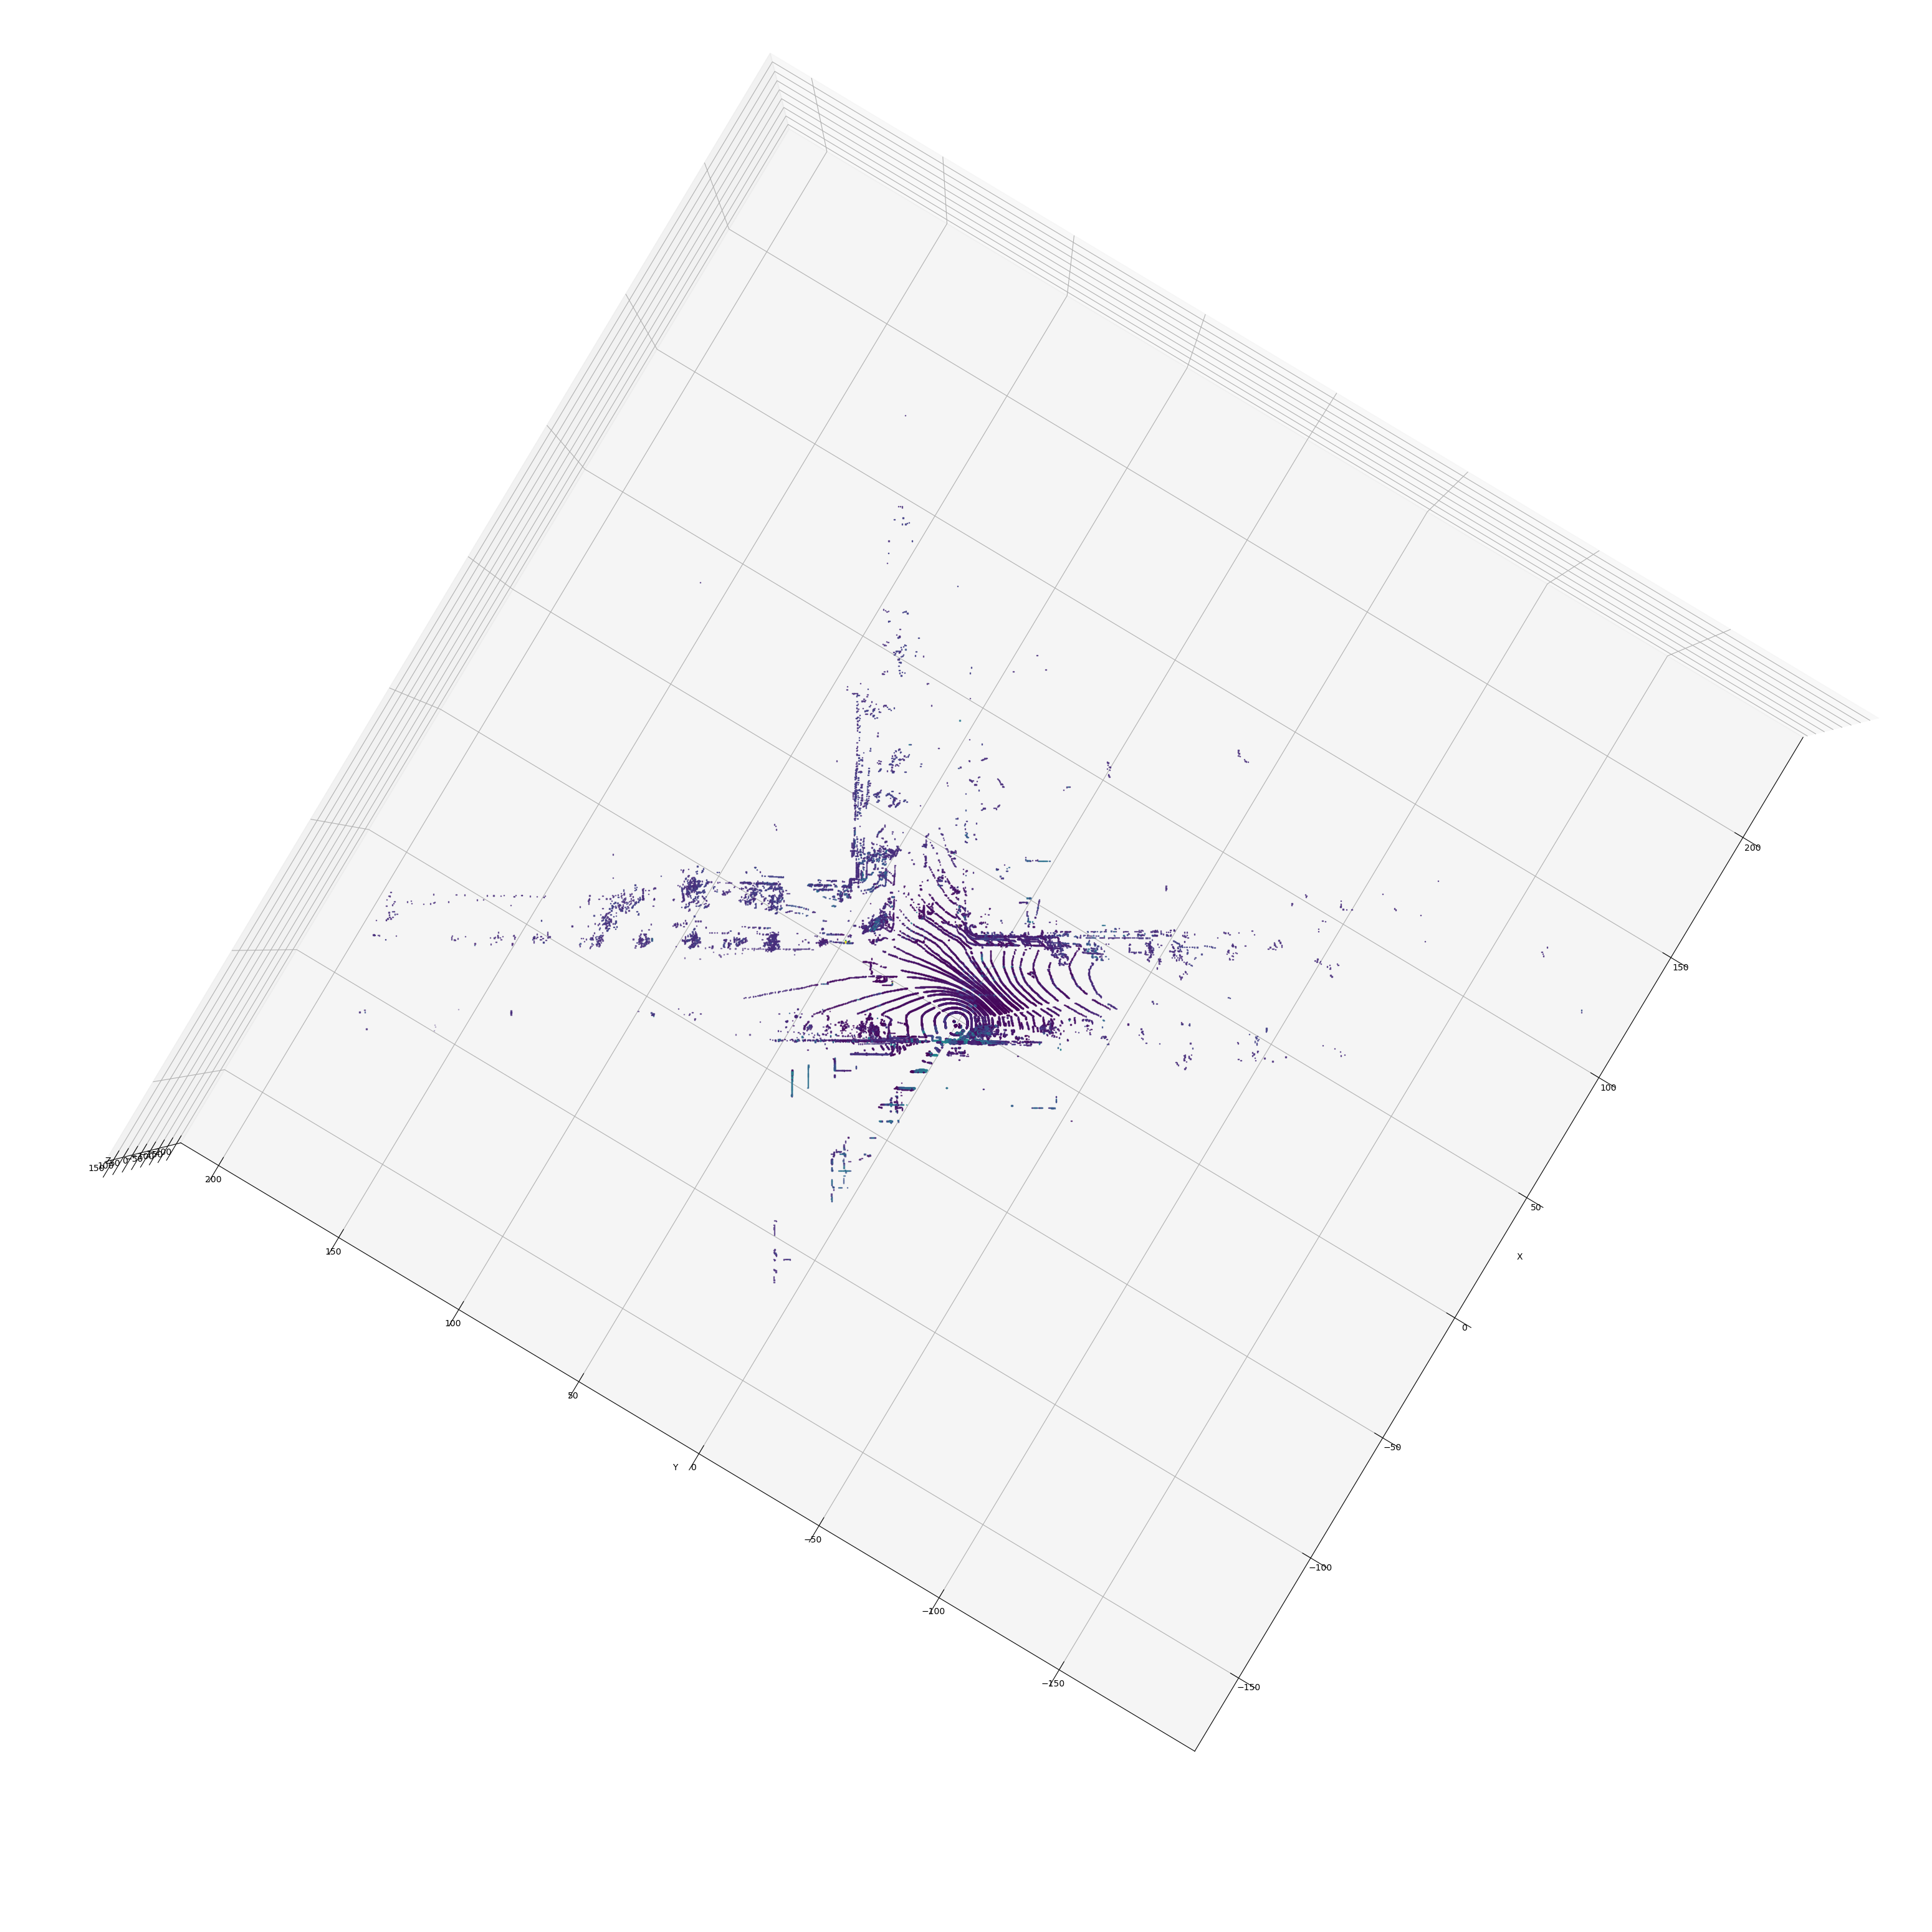

In [78]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(x, y, z, c=intensities, s=1, cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()